# Pursuit Evasion Game Evolutionary Algorithm

### Pursuit Evasion Games

Pursuit Evasion Games are a subclass of non-cooperative games. The simplest case includes a pursuer and an evader, which in our case are referred to as the predator and prey respectively. The pursuer's objective is to catch the evader, while the evader must avoid capture. This is a zero-sum game of competing interests. The characteristics of the two players are different. In our experiment we give the predator an advantage in top speed, whereas the prey has an agility advantage, encoded as having a higher acceleration. 

### Game Structure
The game has been defined in the `00_Deterministic` notebook, where we also added functionality to simulate, plot, and perform signal processing through discrete cosine transform. The purpose of `00_Deterministic` is to explore the different behaviors that can emerge from this Differential Game. In the next section we will take this game, tweak its architecture and propose an evolutionary algorithm to find the predator and prey's best parameters.

In [1]:
# imports
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

from game import PredatorPreyGame

## Genomes

The first step to evolution is a basic structure to hold the genetic information of the individuals. For this reason, a unqiue genome needs to be defined for the prey and predator. 

**Predator** \
The predator has the max speed and acceleration parameters, to find the best speed and acceleration combination, as well as a `predicition_factor`, which could be described as how much to look ahead at where the prey could be, and finally a `pursuit_strategy`, what the best way to follow the prey is.

**Prey** \
The prey also has the max speed and acceleration parameters, but is also equipped with the ability to change its `reaction_radius`, how close the predator has to be for it to start evading, and its `evasion_angle`, the direction the prey will take to evade.

In [ ]:
class PreyGenome:
    def __init__(self):
        self.react_radius = 20.0
        self.evasion_angle = np.pi/2
        self.evasion_time = 3.0

### Simulation Runner

This function serves as our simulation engine, taking a prey genome and simulation parameters to run a complete predator-prey chase scenario. It creates a new game instance with the specified prey genome and runs the simulation until either:
- The predator catches the prey (`game.game_over` becomes True)
- The maximum simulation time is reached

The function returns the completed game object, which contains all the simulation data needed for fitness evaluation.


In [ ]:
def run_simulation(prey_genome, simulation_params):
    game = PredatorPreyGame(width=simulation_params['width'], height=simulation_params['height'], prey_genome=prey_genome)

    while not game.game_over and game.time_elapsed < simulation_params['max_time']:
        game.update(dt=simulation_params['dt'])
    
    return game

## Fitness Function

The next important part of an evolutionary algorithm is the fitness function, to quantify how well the current genetic combination of prey and predator are performing. This metric will be important in deciding the "survival of the fittest", the best genomes that will go on to reproduce and create the new offspring of agents. Again, we will need a unique way of assessing the fitness of predators and prey, as they have distinct, and competing, interests.

**Predator** \
The predator's goal is to catch the prey, so we can start by giving the predator `0` reward if the prey is not caught within the allotted time or distance. From this, a natural fitness measure could be the `capture_time`, where the lower this value is, the better the predator's performance. In addition, we could also look at the predator's `pursuit_efficiency`, which is defined by dividing the straight line distance between the predator's initial position and the eventual capture, and the distance that the predator actual travelled within the simulation.

**Prey** \  
For the prey there are a few metrics that could help us understand how well it is evading its pursuer. For one, `survival_time` is crucial, because the longer the prey evades capture, the more effectively it is out of reach of the predator's hungry fangs. We could also look at `total_distance` travelled, which would tell us how far the prey got before it was taken down. Another metric could be a calculation of the `average_distance` the prey was able to keep between itself and the predator. One can imagine that a few strategies may arise for the prey, namely, getting as far away from the predator, and maintaining that distance, but also being just out of reach for the predator, making use of its agility. Because of this, we will be implementing a more nuanced fitness function, rewarding both distance and time away from the predator.

In [4]:
# Prey Fitness
def prey_fitness(game):
    """
    Fitness function for prey: survival time
    """
    survival_time = game.get_survival_time()
    
    # Calculate distance from initial position to final position
    if len(game.prey_trail) < 1:
        final_distance = 0.0
    else:
        initial_x, initial_y = game.prey_trail[0]
        final_x, final_y = game.prey_trail[-1]
        final_distance = np.sqrt((final_x - initial_x)**2 + (final_y - initial_y)**2)
    
    # Normalize survival time
    max_time = 50.0
    normalized_survival_time = min(survival_time / max_time, 1.0)
    
    # Normalize final distance (max possible is arena diagonal)
    arena_diagonal = np.sqrt(game.width**2 + game.height**2)
    normalized_distance = min(final_distance / arena_diagonal, 1.0)
    
    # Weighted combination
    fitness = 0.9 * normalized_survival_time + 0.1 * normalized_distance
    
    return fitness

## Variation Operators

Next we need to define the evolutionary operators, that are needed to generate new candidate solutions. The operators are divided into different types based on their arity, the number of inputs that go into the variation. The selection operator does not have an arity as it acts as more of a filtering operator, selecting a subset out of all individuals that will be able to reproduce.
- $\mathrm{Arity} = 1$: mutation operator
- $\mathrm{Arity} > 1$: recombination operator
- $\mathrm{Arity} = 2$: crossover operator

Our experiment will not be implementing crossover, instead we will focus on selection, mutation, and recombination.

### Selection
Selection is the process of picking individuals from a population to serve as parents for the next generation of offspring. The operator evaluates the fitness of each individual and probabilistically favors those with higher fitness, guiding the evolutionary process toward better solutions. Selection does not modify the individuals themselves but determines which genotypes are allowed to reproduce. It ensures that advantageous traits are more likely to be propagated, while also maintaining genetic diversity to avoid premature convergence.

### Mutation
The mutation is a unary variation operator that is applied to one genotype and delivers a slightly modified mutant, which is referred to as the child or offspring. This operator acts on one genotype and returns another. It causes a small, random variation, which may or may not help improve the fitness of its offspring. These mutations help the species explore new territory in the parameter space, effectively guaranteeing that the space is connected. The element of randomness is essential to its functioning, as well as differentiating it from other unary heuristic operators.

### Recombination
Recombination is a binary variation operator with the role of merging information from two parent genotypes into their offspring genotypes. The choice of what information is merged is stochastic. There is a chance that through recombination, the offspring performs as well, or even worse than the parents. Yet the hope is that in combining parents genotypes, the emerging combination of genomes in the offspring represents an improvement in the fitness of the individual.


In [5]:
def mutate_genome(genome, attr_ranges: dict, rate: float = 0.2, strength: float = 0.2):
    """
    Mutate a genome with a given rate and strength
    """
    mutated = PreyGenome()

    for attr, (min_val, max_val) in attr_ranges.items():
        val = getattr(genome, attr)
        if random.random() < rate:
            val += random.gauss(0, strength * (max_val-min_val))
            val = max(min_val, min(max_val, val))
            if "angle" in attr:  # keep angles in [0, 2π]
                val = val % (2 * np.pi)
        setattr(mutated, attr, val)
    return mutated

prey_ranges = {  
    "react_radius": (5.0, 50.0), 
    "evasion_angle": (0.0, 2.0 * np.pi),
    "evasion_time": (1.0, 10.0)
}

def mutate_prey(genome, rate=0.2, strength=0.2):
    return mutate_genome(genome, prey_ranges, rate, strength)

def recombine_genome(parent1, parent2, crossover_rate: float, attributes: List[str]):
    child1, child2 = PreyGenome(), PreyGenome()
    # no crossover
    if random.random() > crossover_rate:
        return parent1, parent2
    for attr in attributes:
        if random.random() < 0.5:
            setattr(child1, attr, getattr(parent1, attr))
            setattr(child2, attr, getattr(parent2, attr))
        else:
            setattr(child1, attr, getattr(parent2, attr))
            setattr(child2, attr, getattr(parent1, attr))
    return child1, child2

def recombine_prey(p1, p2, rate=0.7):
    return recombine_genome(p1, p2, rate, ["react_radius", "evasion_angle", "evasion_time"])

## Tournament Selection

Next, we need to define a mechanism to make use of the fitness values to drive the evolutionary adaption. We need a way for generations to improve upon themselves through a selection method. We will pick the tournament selection algorithm. This method simulates natural selection by repeatedly choosing a subset (the "tournament") of individuals from the population at random and selecting the one with the highest fitness for reproduction. The underlying assumption is that individuals with better strategies, e.g. more effective evasion angle or better-timed evasions, should be more likely to contribute to future generations. By maintaining a balance between selection pressure and genetic diversity, tournament selection helps evolve increasingly effective predator and prey behaviors across generations, ultimately guiding the system toward optimal or near-optimal pursuit or evasion strategies.

### Tournament Selection Implementation

The tournament selection function implements a competitive selection mechanism that balances selection pressure with genetic diversity. For each position in the next generation:

1. A random subset of individuals (tournament size = 5) is selected from the current population
2. The individual with the highest fitness in this tournament wins and is selected for reproduction
3. This process repeats until we have selected enough parents for the next generation

This approach ensures that fit individuals are more likely to be selected while still giving less fit individuals a chance to contribute, preventing premature convergence and maintaining population diversity.


In [ ]:
def tournament_selection(population, fitness_values, tournament_size=5):
    """
    Select individuals for reproduction using tournament selection
    """
    selected = []
    for _ in range(len(population)):
        # Randomly select tournament_size individuals
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitness = [fitness_values[i] for i in tournament_indices]
        
        # Select the best individual from the tournament
        winner_index = tournament_indices[np.argmax(tournament_fitness)]
        selected.append(population[winner_index])
    
    return selected

## Populations

In order for the species to properly evolve, multiple different genomes need to be initialized. This is done through a population. Populations give species a pool of other similar species to mate with, allowing the mixing and transfer of genomes to offspring.

### Population Initialization

The `initialize_prey_population` function creates the initial generation of prey individuals with randomly distributed genetic parameters. Each prey genome is initialized with:
- Random reaction radius between 5.0 and 50.0 units
- Random evasion angle between 0 and 2π radians
- Random evasion time between 1.0 and 10.0 seconds

This random initialization ensures genetic diversity at the start of evolution, providing a broad sampling of the parameter space for the evolutionary algorithm to explore and optimize.


In [ ]:
def initialize_prey_population(population_size):
    """
    Initialize prey population with random genomes
    """
    population = []
    for _ in range(population_size):
        genome = PreyGenome()
        genome.react_radius = np.random.uniform(5.0, 50.0)
        genome.evasion_angle = np.random.uniform(0.0, 2 * np.pi)
        genome.evasion_time = np.random.uniform(1.0, 10.0)
        population.append(genome)
    return population

## Main Evolution Loop

### Population Evaluation Function

The `evaluate_prey_population` function assesses the fitness of each individual in the population by running multiple simulation trials and averaging the results. This approach:

1. Reduces the impact of random variation in individual simulations
2. Provides more reliable fitness estimates for each genome
3. Helps identify consistently good strategies rather than lucky outcomes

Each prey individual is tested across multiple trials (default 5), and their average fitness score is used for selection and reproduction decisions. This multi-trial evaluation is crucial for robust evolutionary progress in stochastic environments.


In [ ]:
def evaluate_prey_population(prey_population, simulation_params, n_trials=5):
    """
    Evaluate each prey by running multiple simulations and averaging the fitness
    """
    fitness_values = []
    for prey in prey_population:
        total_fitness = 0
        for _ in range(n_trials):
            game = run_simulation(prey, simulation_params)
            total_fitness += prey_fitness(game)
        fitness_values.append(total_fitness / n_trials)
    return fitness_values

### Main Evolutionary Algorithm

The `evolve_preys` function implements the complete evolutionary algorithm loop. This is the core function that orchestrates the entire evolutionary process:

**Algorithm Steps**:
1. Initialize a random population of prey genomes
2. For each generation:
   - Evaluate fitness of all individuals through multiple simulation trials
   - Select parents using tournament selection
   - Track the best individual and fitness progress
   - Create offspring through recombination and mutation
   - Apply elitism by preserving the best individual

**Key Features**:
- **Elitism**: The best individual from each generation is automatically carried forward
- **Progress Tracking**: Fitness history and best individuals are recorded for analysis
- **Configurable Parameters**: Population size, mutation rates, and crossover rates can be adjusted

The function returns the final evolved population along with historical data for visualization and analysis.


In [9]:
def evolve_preys(simulation_params, prey_pop_size=50, generations=100,
           mutation_rate=0.2, mutation_strength=0.2, crossover_rate=0.7):
    """
    Main evolutionary algorithm loop that evolves prey populations
    """
    # Initialize populations
    prey_population = initialize_prey_population(prey_pop_size)
    fitness_history = []
    best_prey_history = []
    
    for generation in range(generations):
        print(f"Generation {generation+1}/{generations}")
        
        # Evaluate fitness
        fitness_values = evaluate_prey_population(prey_population, simulation_params)
        
        # Select parents using tournament selection
        prey_parents = tournament_selection(prey_population, fitness_values)
        
        # Find best prey
        best_prey_idx = np.argmax(fitness_values)
        fitness_history.append(fitness_values[best_prey_idx])
        best_prey = prey_population[best_prey_idx]
        best_prey_history.append(best_prey)
        
        # Print progress
        print(f"  Best prey fitness: {fitness_history[-1]:.4f}")
        
        # Create new generation with recombination and mutation
        new_prey_population = []
        for i in range(0, prey_pop_size, 2):
            # Select two parents
            parent1 = prey_parents[i % len(prey_parents)]
            parent2 = prey_parents[(i + 1) % len(prey_parents)]
            # Create offspring through recombination
            child1, child2 = recombine_prey(parent1, parent2, crossover_rate)
            # Mutate offspring
            child1 = mutate_prey(child1, mutation_rate, mutation_strength)
            child2 = mutate_prey(child2, mutation_rate, mutation_strength)
            # Add to new population
            new_prey_population.append(child1)
            if len(new_prey_population) < prey_pop_size:
                new_prey_population.append(child2)
        
        # Elitism: keep the best individual from previous generation
        new_prey_population[0] = best_prey
        prey_population = new_prey_population
    
    return prey_population, fitness_history, best_prey_history

### Experimental Execution and Results Analysis

This section runs the complete evolutionary experiment with carefully chosen parameters:

**Simulation Parameters**:
- Arena size: 100x100 units
- Time step: 0.1 seconds for smooth simulation
- Maximum simulation time: 100 seconds per trial

**Evolution Parameters**:
- Population size: 10 (small for demonstration purposes)
- Generations: 30 (sufficient to observe evolutionary trends)
- Higher mutation rate (0.3) and strength (0.25) to encourage exploration

After evolution completes, the code provides comprehensive analysis including:
- Fitness progression visualization
- Best individual parameter display
- Simulation visualization with the evolved prey behavior

Generation 1/30
  Best prey fitness: 0.9226
Generation 2/30
  Best prey fitness: 0.9263
Generation 3/30
  Best prey fitness: 0.9246
Generation 4/30
  Best prey fitness: 0.9263
Generation 5/30
  Best prey fitness: 0.9269
Generation 6/30
  Best prey fitness: 0.9265
Generation 7/30
  Best prey fitness: 0.9270
Generation 8/30
  Best prey fitness: 0.9264
Generation 9/30
  Best prey fitness: 0.9262
Generation 10/30
  Best prey fitness: 0.9262
Generation 11/30
  Best prey fitness: 0.9260
Generation 12/30
  Best prey fitness: 0.9260
Generation 13/30
  Best prey fitness: 0.9261
Generation 14/30
  Best prey fitness: 0.9262
Generation 15/30
  Best prey fitness: 0.9261
Generation 16/30
  Best prey fitness: 0.9264
Generation 17/30
  Best prey fitness: 0.9264
Generation 18/30
  Best prey fitness: 0.9263
Generation 19/30
  Best prey fitness: 0.9265
Generation 20/30
  Best prey fitness: 0.9268
Generation 21/30
  Best prey fitness: 0.9267
Generation 22/30
  Best prey fitness: 0.9265
Generation 23/30
  

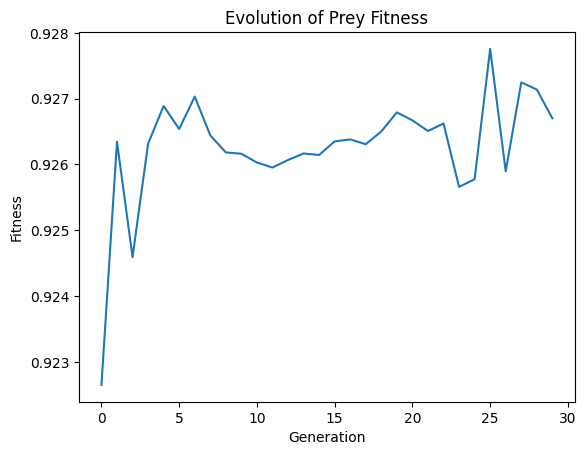


Best Prey:
  Reaction Radius: 5.00
  Evasion Angle: 0.57 deg = 32.4°
  Evasion Time: 6.06


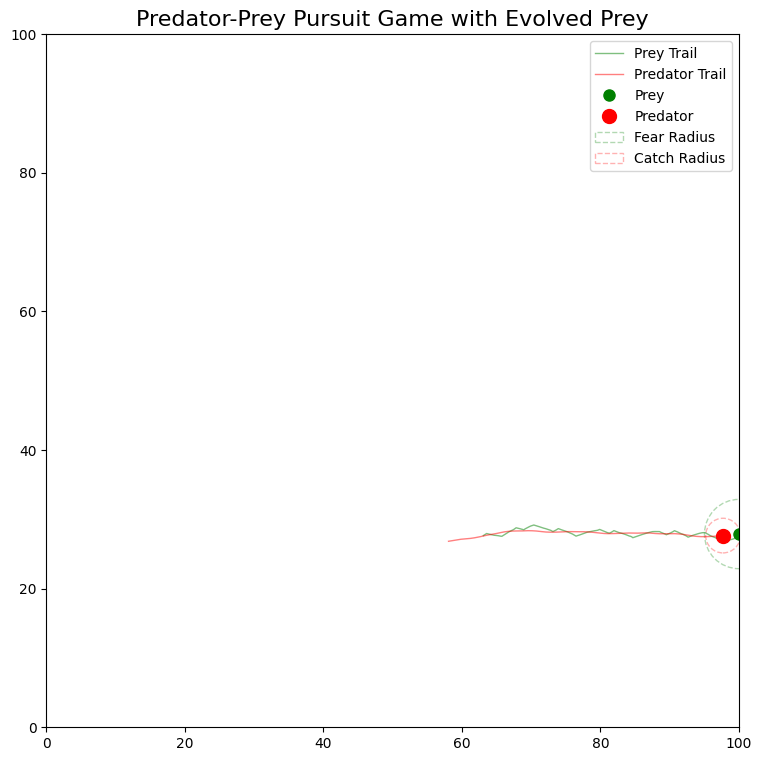

In [10]:
# Simulation parameters
simulation_params = {
    'dt': 0.1,
    'width': 100,
    'height': 100,
    'max_time': 100  # Maximum simulation time
}
    
# Run evolution
prey_pop, prey_history, best_prey_history = evolve_preys(
    simulation_params,
    prey_pop_size=10,
    generations=30,
    mutation_rate=0.3,
    mutation_strength=0.25
)

# Visualize evolution progress
def visualize_evolution(fitness_history):
    plt.plot(fitness_history)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Evolution of Prey Fitness")
    plt.show()

visualize_evolution(prey_history)

# Get best individual from final generation
best_prey = best_prey_history[-1]

print("\nBest Prey:")
print(f"  Reaction Radius: {best_prey.react_radius:.2f}")
print(f"  Evasion Angle: {best_prey.evasion_angle:.2f} deg = {best_prey.evasion_angle * 180 / np.pi:.1f}°")
print(f"  Evasion Time: {best_prey.evasion_time:.2f}")

# Visualize a simulation with the best individual
def visualize_best_simulation(best_prey, simulation_params):
    game = run_simulation(best_prey, simulation_params)
    
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_xlim(0, game.width)
    ax.set_ylim(0, game.height)
    ax.set_aspect('equal')
    ax.set_title('Predator-Prey Pursuit Game with Evolved Prey', fontsize=16)
    
    # Plot prey and predator trails
    prey_x, prey_y = zip(*game.prey_trail)
    pred_x, pred_y = zip(*game.predator_trail)
    ax.plot(prey_x, prey_y, 'g-', alpha=0.5, linewidth=1, label='Prey Trail')
    ax.plot(pred_x, pred_y, 'r-', alpha=0.5, linewidth=1, label='Predator Trail')
    
    # Plot final positions
    ax.plot(game.prey.x, game.prey.y, 'go', markersize=8, label='Prey')
    ax.plot(game.predator.x, game.predator.y, 'ro', markersize=10, label='Predator')
    
    # Fear radius circle
    fear_circle = plt.Circle((game.prey.x, game.prey.y), game.prey.react_radius, 
                           fill=False, color='green', alpha=0.3, linestyle='--', label='Fear Radius')
    ax.add_patch(fear_circle)
    
    # Catch radius circle
    catch_circle = plt.Circle((game.predator.x, game.predator.y), game.predator.catch_radius, 
                            fill=False, color='red', alpha=0.3, linestyle='--', label='Catch Radius')
    ax.add_patch(catch_circle)
    
    ax.legend(loc='upper right')
    plt.show()

visualize_best_simulation(best_prey, simulation_params)

### Future Extensions and Conclusions

This evolutionary algorithm successfully demonstrates how artificial evolution can optimize prey evasion strategies in a predator-prey pursuit game. The algorithm evolves three key behavioral parameters to maximize survival time while encouraging exploration of the environment.

**Potential Extensions**:
- Co-evolution of both predator and prey populations
- Multi-objective optimization considering energy expenditure
- Dynamic environments with obstacles or changing conditions
- Analysis of emergent behavioral strategies and their stability
- Implementation of more sophisticated neural network-based controllers
